# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_n_snps_used_sharing_and_log"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, check_n_lvs=True, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lvs = results["lv"].unique()
    n_observed_lvs = len(observed_lvs)
    if check_n_lvs:
        assert n_observed_lvs == 1
        observed_lv = observed_lvs[0]
    else:
        observed_lv = f"All LVs ({n_observed_lvs})"

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_n_snps_used_sharing_and_log/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.007935,0.012456,0.637002,0.524146,0.262073,random.pheno988
1,LV2,0.016208,0.012457,1.301140,0.193257,0.096629,random.pheno988
2,LV3,-0.011065,0.012478,-0.886760,0.375241,0.812379,random.pheno988
3,LV4,-0.014062,0.012471,-1.127576,0.259541,0.870229,random.pheno988
4,LV5,0.001626,0.012460,0.130519,0.896160,0.448080,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.060613981762917934

# QQ-plot

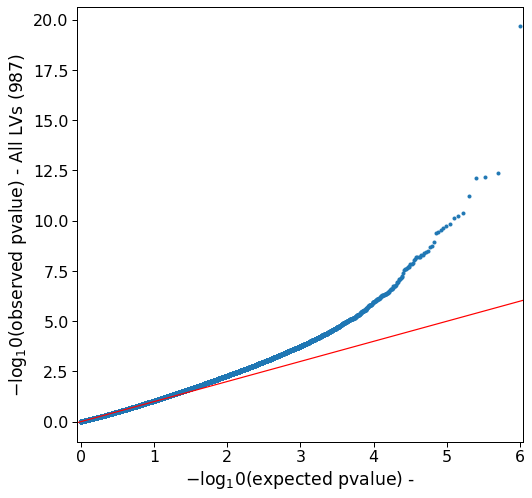

In [18]:
qqplot_unif(dfs, check_n_lvs=False)

# Summary of mean type I error per LV

In [19]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [20]:
summary_df.shape

(987, 4)

In [21]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.036,0.064
1,LV10,0.013,0.049,0.085
2,LV100,0.018,0.052,0.098
3,LV101,0.017,0.052,0.095
4,LV102,0.011,0.056,0.100


In [22]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016672,0.060614,0.108782
std,0.007959,0.015808,0.022164
min,0.002000,0.014000,0.031000
25%,0.012000,0.050000,0.094500
50%,0.016000,0.059000,0.108000
75%,0.020000,0.069000,0.122000
max,0.104000,0.160000,0.225000


## LVs with expected type I error

In [23]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(75, 4)

,lv,1,5,10
1,LV10,0.013,0.049,0.085
388,LV449,0.015,0.049,0.094
431,LV488,0.013,0.049,0.097
438,LV494,0.009,0.049,0.094
470,LV522,0.018,0.049,0.091
532,LV579,0.012,0.049,0.094
608,LV647,0.009,0.049,0.084
609,LV648,0.007,0.049,0.087
618,LV656,0.013,0.049,0.084
624,LV661,0.010,0.049,0.112


,lv,1,5,10
759,LV783,0.014,0.051,0.089
347,LV411,0.012,0.051,0.113
61,LV154,0.010,0.051,0.095
314,LV382,0.007,0.051,0.100
361,LV424,0.014,0.051,0.091
415,LV473,0.016,0.051,0.112
426,LV483,0.015,0.051,0.089
432,LV489,0.008,0.051,0.099
233,LV309,0.009,0.051,0.080
490,LV540,0.016,0.051,0.105


## LVs with high type I error

In [24]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(472, 4)

,lv,1,5,10
694,LV724,0.031,0.096,0.155
190,LV270,0.033,0.096,0.162
213,LV291,0.042,0.098,0.140
382,LV443,0.040,0.100,0.135
28,LV124,0.037,0.101,0.152
631,LV668,0.032,0.102,0.165
142,LV227,0.043,0.103,0.144
471,LV523,0.033,0.104,0.171
961,LV965,0.038,0.104,0.157
557,LV600,0.034,0.105,0.177


# LVs with high mean type I error

In [25]:
lv_results_high = {}

## LV45

In [26]:
lv_code = "LV45"

In [27]:
results = dfs[dfs["lv"] == lv_code]

In [28]:
results.shape

(1000, 7)

In [29]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.005581,0.012466,0.447732,0.654361,0.327181,random.pheno988
1031,LV45,0.000996,0.012474,0.079879,0.936336,0.468168,random.pheno589
2018,LV45,0.000994,0.012472,0.079683,0.936492,0.468246,random.pheno385
3005,LV45,0.006067,0.012470,0.486498,0.626631,0.313315,random.pheno5
3992,LV45,-0.009163,0.012474,-0.734518,0.462660,0.768670,random.pheno74


In [30]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [31]:
show_prop(results, 0.01)

0.104

In [32]:
show_prop(results, 0.05)

0.16

In [33]:
show_prop(results, 0.10)

0.225

In [34]:
show_prop(results, 0.15)

0.262

In [35]:
show_prop(results, 0.20)

0.296

### QQplot

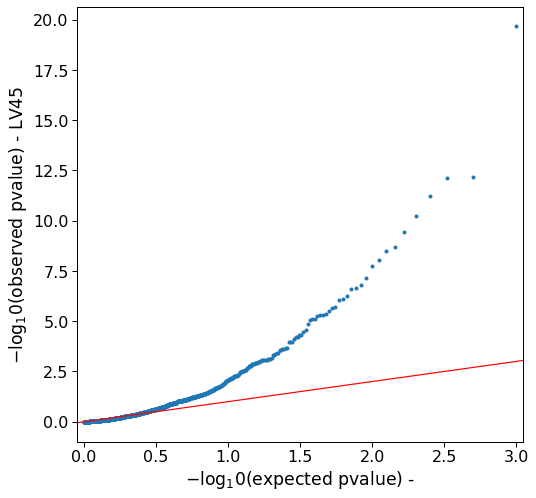

In [36]:
qqplot_unif(results)

## LV234

In [37]:
lv_code = "LV234"

In [38]:
results = dfs[dfs["lv"] == lv_code]

In [39]:
results.shape

(1000, 7)

In [40]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.004305,0.012453,0.345722,0.729563,0.364782,random.pheno988
1220,LV234,-0.001418,0.012462,-0.113778,0.909417,0.545291,random.pheno589
2207,LV234,0.002486,0.012460,0.199528,0.841856,0.420928,random.pheno385
3194,LV234,0.012500,0.012457,1.003404,0.315704,0.157852,random.pheno5
4181,LV234,0.011733,0.012462,0.941536,0.346465,0.173233,random.pheno74


In [41]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [42]:
show_prop(results, 0.01)

0.086

In [43]:
show_prop(results, 0.05)

0.155

In [44]:
show_prop(results, 0.10)

0.209

In [45]:
show_prop(results, 0.15)

0.24

In [46]:
show_prop(results, 0.20)

0.286

### QQplot

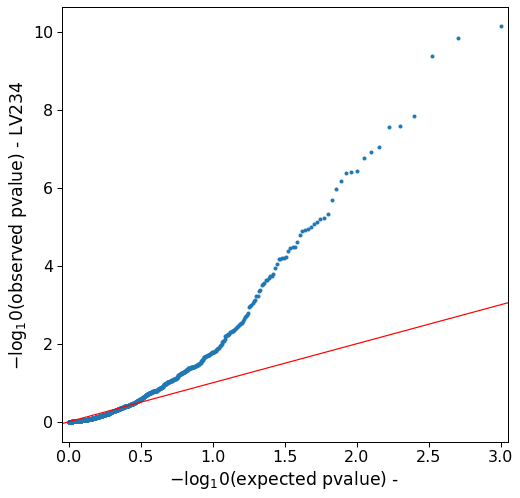

In [47]:
qqplot_unif(results)

## LV847

In [48]:
lv_code = "LV847"

In [49]:
results = dfs[dfs["lv"] == lv_code]

In [50]:
results.shape

(1000, 7)

In [51]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.004178,0.012455,-0.335418,0.737321,0.631340,random.pheno988
1833,LV847,0.001323,0.012463,0.106126,0.915486,0.457743,random.pheno589
2820,LV847,-0.002885,0.012461,-0.231482,0.816948,0.591526,random.pheno385
3807,LV847,0.007723,0.012459,0.619883,0.535357,0.267678,random.pheno5
4794,LV847,0.014612,0.012463,1.172500,0.241040,0.120520,random.pheno74


In [52]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [53]:
show_prop(results, 0.01)

0.09

In [54]:
show_prop(results, 0.05)

0.142

In [55]:
show_prop(results, 0.10)

0.191

In [56]:
show_prop(results, 0.15)

0.227

In [57]:
show_prop(results, 0.20)

0.264

### QQplot

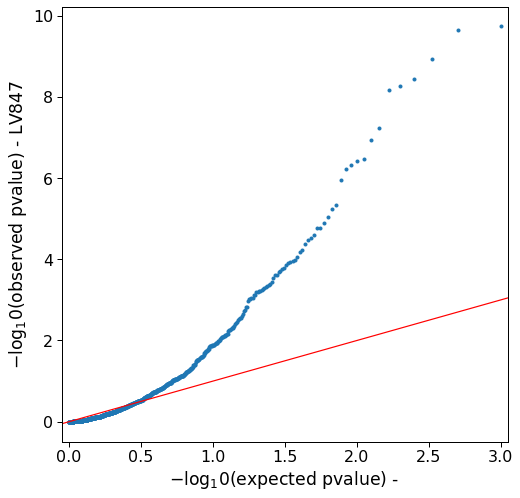

In [58]:
qqplot_unif(results)

## LV110

In [59]:
lv_code = "LV110"

In [60]:
results = dfs[dfs["lv"] == lv_code]

In [61]:
results.shape

(1000, 7)

In [62]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.024187,0.012451,-1.942587,0.052110,0.973945,random.pheno988
1096,LV110,0.000718,0.012463,0.057634,0.954042,0.477021,random.pheno589
2083,LV110,-0.004626,0.012461,-0.371198,0.710502,0.644749,random.pheno385
3070,LV110,-0.006437,0.012459,-0.516676,0.605400,0.697300,random.pheno5
4057,LV110,0.009897,0.012463,0.794067,0.427185,0.213593,random.pheno74


In [63]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [64]:
show_prop(results, 0.01)

0.077

In [65]:
show_prop(results, 0.05)

0.127

In [66]:
show_prop(results, 0.10)

0.176

In [67]:
show_prop(results, 0.15)

0.211

In [68]:
show_prop(results, 0.20)

0.251

### QQplot

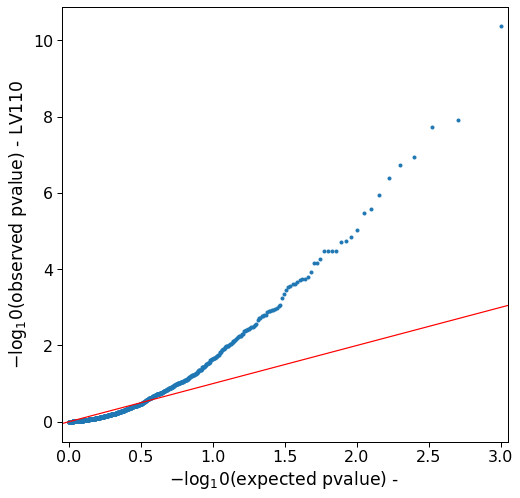

In [69]:
qqplot_unif(results)

## LV769

In [70]:
lv_code = "LV769"

In [71]:
results = dfs[dfs["lv"] == lv_code]

In [72]:
results.shape

(1000, 7)

In [73]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.013068,0.012453,1.049365,0.294050,0.147025,random.pheno988
1755,LV769,0.001302,0.012462,0.104467,0.916802,0.458401,random.pheno589
2742,LV769,0.001910,0.012460,0.153265,0.878194,0.439097,random.pheno385
3729,LV769,-0.020918,0.012456,-1.679360,0.093131,0.953435,random.pheno5
4716,LV769,-0.018982,0.012461,-1.523348,0.127721,0.936140,random.pheno74


In [74]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [75]:
show_prop(results, 0.01)

0.039

In [76]:
show_prop(results, 0.05)

0.123

In [77]:
show_prop(results, 0.10)

0.198

In [78]:
show_prop(results, 0.15)

0.252

In [79]:
show_prop(results, 0.20)

0.309

### QQplot

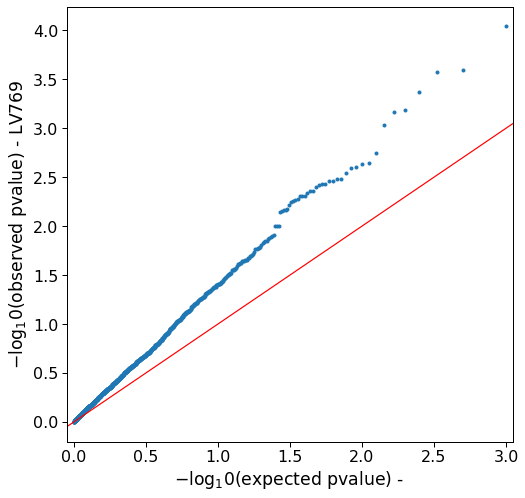

In [80]:
qqplot_unif(results)

## LV800

In [81]:
lv_code = "LV800"

In [82]:
results = dfs[dfs["lv"] == lv_code]

In [83]:
results.shape

(1000, 7)

In [84]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.012286,0.012458,0.986189,0.324077,0.162039,random.pheno988
1786,LV800,0.002874,0.012467,0.230522,0.817693,0.408847,random.pheno589
2773,LV800,-0.009900,0.012464,-0.794273,0.427066,0.786467,random.pheno385
3760,LV800,-0.022080,0.012460,-1.772015,0.076439,0.961780,random.pheno5
4747,LV800,-0.009076,0.012467,-0.728008,0.466635,0.766682,random.pheno74


In [85]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [86]:
show_prop(results, 0.01)

0.048

In [87]:
show_prop(results, 0.05)

0.119

In [88]:
show_prop(results, 0.10)

0.185

In [89]:
show_prop(results, 0.15)

0.219

In [90]:
show_prop(results, 0.20)

0.263

### QQplot

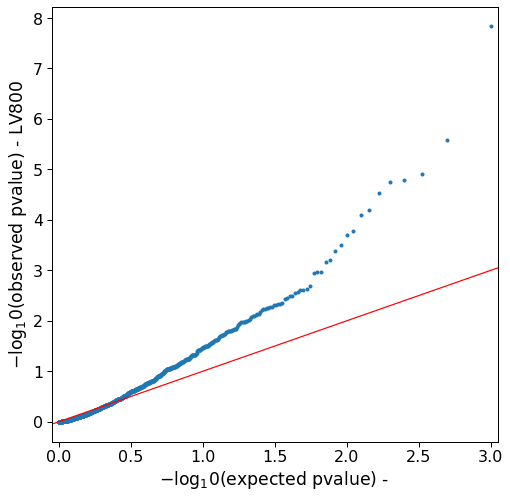

In [91]:
qqplot_unif(results)

# LVs with expected mean type I error

In [92]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
1,LV10,0.013,0.049,0.085
388,LV449,0.015,0.049,0.094
431,LV488,0.013,0.049,0.097
438,LV494,0.009,0.049,0.094
470,LV522,0.018,0.049,0.091
532,LV579,0.012,0.049,0.094
608,LV647,0.009,0.049,0.084
609,LV648,0.007,0.049,0.087
618,LV656,0.013,0.049,0.084
624,LV661,0.010,0.049,0.112


In [93]:
lv_results_expected = {}

## LV412

In [94]:
lv_code = "LV412"

In [95]:
results = dfs[dfs["lv"] == lv_code]

In [96]:
results.shape

(1000, 7)

In [97]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.009507,0.012461,-0.762954,0.445519,0.777241,random.pheno988
1398,LV412,-0.016192,0.012468,-1.298703,0.194092,0.902954,random.pheno589
2385,LV412,0.020054,0.012465,1.608840,0.107700,0.053850,random.pheno385
3372,LV412,0.009302,0.012465,0.746197,0.455576,0.227788,random.pheno5
4359,LV412,0.010069,0.012470,0.807487,0.419416,0.209708,random.pheno74


In [98]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [99]:
show_prop(results, 0.01)

0.009

In [100]:
show_prop(results, 0.05)

0.049

In [101]:
show_prop(results, 0.10)

0.105

In [102]:
show_prop(results, 0.15)

0.148

In [103]:
show_prop(results, 0.20)

0.186

### QQplot

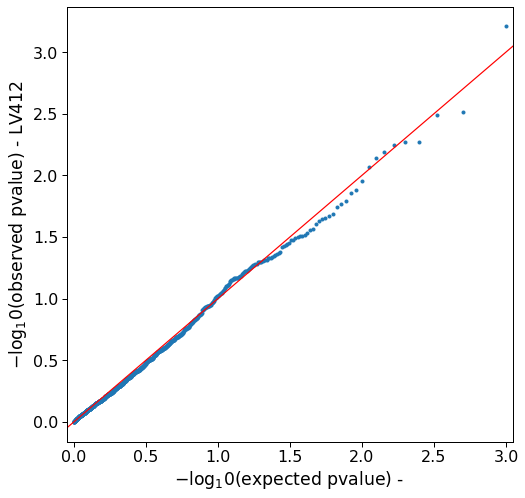

In [104]:
qqplot_unif(results)

## LV57

In [105]:
lv_code = "LV57"

In [106]:
results = dfs[dfs["lv"] == lv_code]

In [107]:
results.shape

(1000, 7)

In [108]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020774,0.012452,-1.668243,0.095316,0.952342,random.pheno988
1043,LV57,0.024029,0.012460,1.928572,0.053828,0.026914,random.pheno589
2030,LV57,0.015463,0.012460,1.241008,0.214648,0.107324,random.pheno385
3017,LV57,-0.003794,0.012460,-0.304471,0.760779,0.619610,random.pheno5
4004,LV57,0.014064,0.012463,1.128478,0.259160,0.129580,random.pheno74


In [109]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [110]:
show_prop(results, 0.01)

0.012

In [111]:
show_prop(results, 0.05)

0.049

In [112]:
show_prop(results, 0.10)

0.091

In [113]:
show_prop(results, 0.15)

0.138

In [114]:
show_prop(results, 0.20)

0.187

### QQplot

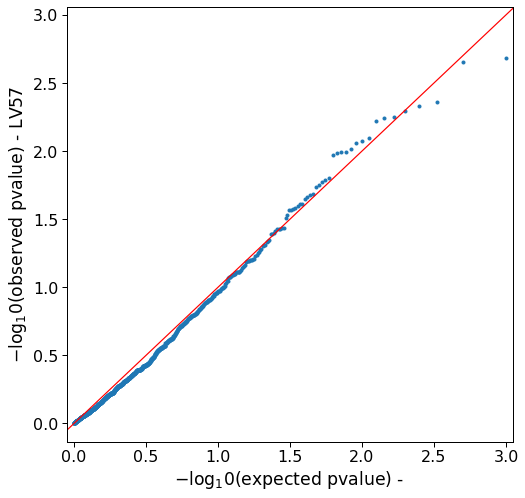

In [115]:
qqplot_unif(results)

## LV647

In [116]:
lv_code = "LV647"

In [117]:
results = dfs[dfs["lv"] == lv_code]

In [118]:
results.shape

(1000, 7)

In [119]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.008295,0.012454,-0.665995,0.505438,0.747281,random.pheno988
1633,LV647,0.000147,0.012463,0.011828,0.990564,0.495282,random.pheno589
2620,LV647,-0.001262,0.012461,-0.101310,0.919308,0.540346,random.pheno385
3607,LV647,0.004623,0.012459,0.371034,0.710624,0.355312,random.pheno5
4594,LV647,0.004304,0.012464,0.345308,0.729874,0.364937,random.pheno74


In [120]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [121]:
show_prop(results, 0.01)

0.009

In [122]:
show_prop(results, 0.05)

0.049

In [123]:
show_prop(results, 0.10)

0.084

In [124]:
show_prop(results, 0.15)

0.132

In [125]:
show_prop(results, 0.20)

0.169

### QQplot

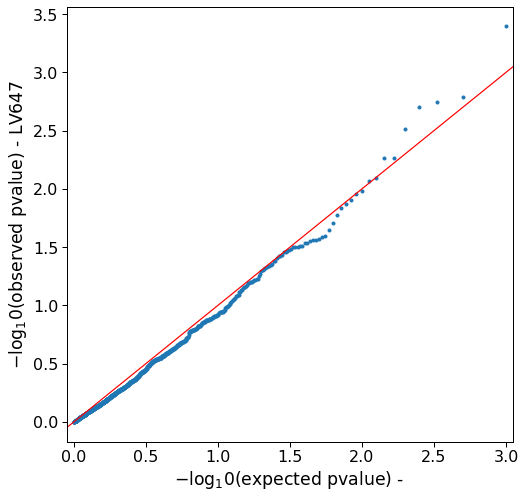

In [126]:
qqplot_unif(results)